In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
import warnings
import geopandas as gpd

In [25]:
# Define a function, which can download trip data for a certain year.

def download(year):
    for i in range(1, 13):
        !curl https://nyc-tlc.s3.amazonaws.com/trip+data/{'fhv_tripdata_' + str(year) + '-' + '%02d'%i + '.csv'} > {'fhv_tripdata_' + str(year) + '-' + '%02d'%i + '.csv'}

In [26]:
# Download data for 2020

download(2020)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  105M  100  105M    0     0  7837k      0  0:00:13  0:00:13 --:--:-- 9396k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91.1M  100 91.1M    0     0  20.8M      0  0:00:04  0:00:04 --:--:-- 20.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.3M  100 67.3M    0     0  18.4M      0  0:00:03  0:00:03 --:--:-- 18.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.3M  100 25.3M    0     0  14.9M      0  0:00:01  0:00:01 --:--:-- 14.9M
  % Total    % Received % Xferd  Average Speed   Tim

In [33]:
# Download data for 2019

download(2019)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1241M  100 1241M    0     0  17.9M      0  0:01:09  0:01:09 --:--:-- 21.1M    0  0:00:57  0:00:17  0:00:40 23.0M     0  16.5M      0  0:01:14  0:00:33  0:00:41 3146k    0  17.8M      0  0:01:09  0:00:49  0:00:20 21.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92.6M  100 92.6M    0     0  22.6M      0  0:00:04  0:00:04 --:--:-- 22.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.1M  100 72.1M    0     0  22.6M      0  0:00:03  0:00:03 --:--:-- 22.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    

In [38]:
# Read all 2019 data to a single dataframe.

fhv2019 = dd.read_csv('/Users/fran/Downloads/midterm-yuzs123456-main/fhv_tripdata_2019-*.csv')
fhv2019 = fhv2019.compute()

In [53]:
# Pick the columns we want.

fhv2019cleaned = fhv2019[['pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID']]

# Filter out na's and duplicates.

fhv2019cleaned = fhv2019cleaned.dropna()
fhv2019cleaned = fhv2019cleaned.drop_duplicates()

In [95]:
# Add a new column 'Date' according to pick-up time.

fhv2019cleaned['pickup_datetime'] = pd.to_datetime(fhv2019cleaned['pickup_datetime'])
fhv2019cleaned['date'] = fhv2019cleaned['pickup_datetime'].dt.date

# Group the data by pick-up location.

fhv2019byPUL = fhv2019cleaned.groupby(['PULocationID']).agg({'DOLocationID': 'count'}).reset_index()

In [96]:
# Filter out the location not in NYC or Wrong (LocationID should belongs to [1, 263])

fhv2019byPUL = fhv2019byPUL.loc[(fhv2019byPUL['PULocationID'] > 0) & (fhv2019byPUL['PULocationID'] < 264)]

# Pick the final two columns for plot

fhv2019byPUL.columns = ['PULocationID', 'Trips']

In [97]:
# Download the shape file from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page and merge the dataframes.
# Read the shapefile.

taxizone = gpd.read_file('/Users/fran/Downloads/taxi_zones/taxi_zones.shp')

# Merge the two dfs by LocationID.

fhv2019geo = taxizone.merge(fhv2019byPUL, left_on='LocationID', right_on='PULocationID', how='left')

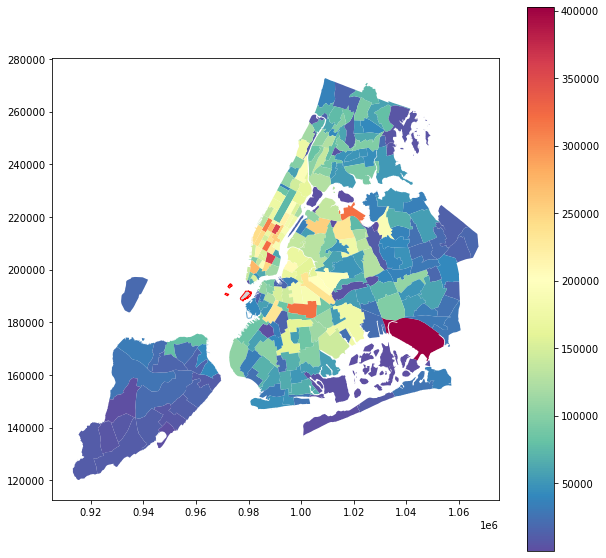

In [99]:
# Plot the numbers of trips by taxi zone.

fhv2019geo.plot(column='Trips',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10),missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values",
                },)

In [102]:
fhv2020 = dd.read_csv('/Users/fran/Downloads/midterm-yuzs123456-main/fhv_tripdata_2020-*.csv')
fhv2020 = fhv2020.compute()

In [103]:
fhv2020cleaned = fhv2020[['pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID']]

fhv2020cleaned = fhv2020cleaned.dropna()
fhv2020cleaned = fhv2020cleaned.drop_duplicates()

In [104]:
fhv2020cleaned['pickup_datetime'] = pd.to_datetime(fhv2020cleaned['pickup_datetime'])
fhv2020cleaned['date'] = fhv2020cleaned['pickup_datetime'].dt.date
fhv2020byPUL = fhv2020cleaned.groupby(['PULocationID']).agg({'DOLocationID': 'count'}).reset_index()

In [105]:
fhv2020byPUL = fhv2020byPUL.loc[(fhv2020byPUL['PULocationID'] > 0) & (fhv2020byPUL['PULocationID'] < 264)]
fhv2020byPUL.columns = ['PULocationID', 'Trips']

In [106]:
# Download the shape file from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page and merge the dataframes.
taxizone = gpd.read_file('/Users/fran/Downloads/taxi_zones/taxi_zones.shp')
fhv2020geo = taxizone.merge(fhv2020byPUL, left_on='LocationID', right_on='PULocationID', how='left')

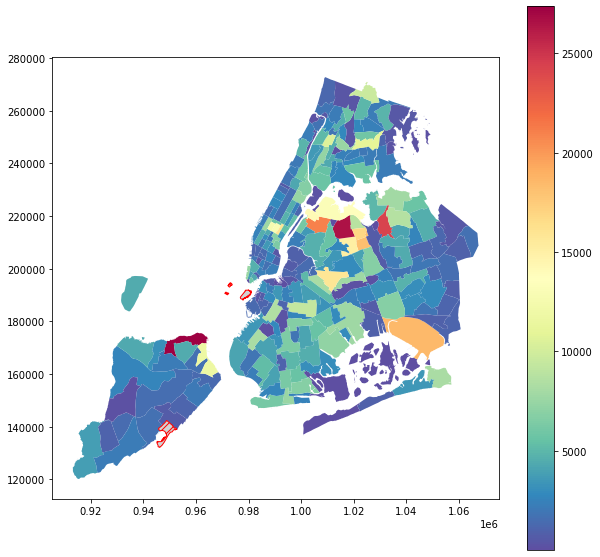

In [107]:
fhv2020geo.plot(column='Trips',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10),missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values",
                },)

In [129]:
# If you want to know which zone has the most trips

max = fhv2020byPUL.Trips.max()

In [126]:
fhv2020byPUL.loc[fhv2020byPUL['Trips'] == max].PULocationID

202    206.0
Name: PULocationID, dtype: float64

In [127]:
taxizone.loc[taxizone['LocationID'] == 202]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
201,202,0.069922,0.000106,Roosevelt Island,202,Manhattan,"POLYGON ((1000370.939 219466.661, 1000158.410 ..."


In [128]:
taxizone.loc[taxizone['LocationID'] == 206]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
205,206,0.212757,0.000944,Saint George/New Brighton,206,Staten Island,"POLYGON ((961436.305 175473.030, 961460.942 17..."


In [130]:
fhv2020byPUL['Trips'].sum()

1041113

In [132]:
fhv2019byPUL['Trips'].sum()

23517566

In [134]:
fhv2020cleaned

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,date
0,2020-01-01 00:30:00,2020-01-01 01:44:00,264.0,264.0,2020-01-01
1,2020-01-01 00:30:00,2020-01-01 00:47:00,264.0,264.0,2020-01-01
2,2020-01-01 00:48:00,2020-01-01 01:19:00,264.0,264.0,2020-01-01
3,2020-01-01 00:34:00,2020-01-01 00:43:00,264.0,264.0,2020-01-01
4,2020-01-01 00:23:00,2020-01-01 00:32:00,264.0,264.0,2020-01-01
...,...,...,...,...,...
683962,2020-05-30 21:30:19,2020-05-30 21:37:34,264.0,56.0,2020-05-30
683963,2020-05-30 21:54:49,2020-05-30 22:10:19,264.0,57.0,2020-05-30
684947,2020-05-30 22:17:30,2020-05-30 22:31:22,264.0,56.0,2020-05-30
684948,2020-05-30 22:36:52,2020-05-30 22:48:33,264.0,82.0,2020-05-30


In [135]:
fhv2019cleaned

,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID
101,2019-01-01 00:33:03,2019-01-01 01:37:24,140.0,52.0
102,2019-01-01 00:03:00,2019-01-01 00:34:25,141.0,237.0
103,2019-01-01 00:45:48,2019-01-01 01:26:01,237.0,236.0
104,2019-01-01 00:37:39,2019-01-01 01:44:59,162.0,85.0
105,2019-01-01 00:35:06,2019-01-01 01:30:21,237.0,246.0
...,...,...,...,...
628348,2019-12-31 23:22:10,2019-12-31 23:30:08,7.0,7.0
628349,2019-12-31 23:37:41,2019-12-31 23:45:39,179.0,179.0
628350,2019-12-31 23:54:59,2020-01-01 00:02:57,193.0,193.0
628351,2019-12-31 23:43:05,2019-12-31 23:51:03,179.0,179.0
